In [141]:
# use with /venvs/vis_learned_brief, when starting the notebook add libpython to the path like:
# $ LD_LIBRARY_PATH=~/anaconda3/lib jupyter notebook

In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras


import numpy as np
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib
import datetime
import imageio
import cv2

Using Theano backend.


In [2]:
# patch_size = 56
# brief_patch_size = 48

patch_size = 65
input_patch_size = 56
brief_patch_size = 48

In [3]:
nr_similar_patches = 5
query_stride = 100
compare_stride = 2
eps = 0.0001

In [4]:
base_dir = '/home/niaki/PycharmProjects/learned-brief/weights'
brief_encoder = load_model(base_dir + '/brief_encoder.h5')

In [5]:
brief_opencv = cv2.xfeatures2d.BriefDescriptorExtractor_create(64, False)
keypoint = cv2.KeyPoint((patch_size - 1) / 2, (patch_size - 1) / 2, _size=brief_patch_size)
keypoints = [keypoint]

In [6]:
type(brief_encoder)

keras.engine.training.Model

In [7]:
type(brief_opencv)

cv2.xfeatures2d_BriefDescriptorExtractor

In [8]:
def calculate_ssd(img1, img2):
    """Computing the sum of squared differences (SSD) between two images."""
    if img1.shape != img2.shape:
        raise Exception("Images don't have the same shape: ", img1.shape, "and", img2.shape)
    return np.sum((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32))**2)


In [9]:
def compute_descriptor(descr, patch):
    assert patch.shape == (patch_size, patch_size), "Patch shape should be (65, 65), and not " + str(patch.shape)
    if type(descr) == keras.engine.training.Model:
        patch = patch / 255.0
        patch_crop = patch[4: 60, 4: 60]
        patch_crop_encoded = brief_encoder.predict(np.expand_dims(np.expand_dims(patch_crop, axis=-1), axis=0))
        patch_crop_encoded_flat = patch_crop_encoded.flatten()
        patch_crop_encoded_flat_binary = patch_crop_encoded_flat.round().astype(int)
        return patch_crop_encoded_flat_binary
    elif type(descr) == cv2.xfeatures2d_BriefDescriptorExtractor:
        
        assert type(patch[0,0]) == np.uint8
#         print(type(patch[0,0]))
        _, descriptors = descr.compute(patch, keypoints)
        patch_descr = descriptors[0]
        patch_descr = np.unpackbits(patch_descr)
        return patch_descr
    
    else:
        raise Exception("Type of descriptor not supported")

In [11]:
image_lenna = imageio.imread('/home/niaki/Code/Lenna.png')
image_lenna = np.dot(image_lenna[ : ,  : , : 3], [0.299, 0.587, 0.114])
image_lenna = image_lenna.astype(np.uint8)
image_briefs = imageio.imread("/home/niaki/PycharmProjects/learned-brief/images/briefs_gray.bmp")
image_hpatches = imageio.imread("/home/niaki/Downloads/hpatches_patch.png")

In [12]:
compute_descriptor(brief_encoder, image_hpatches)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [54]:
fallen_ijs = []
good_ijs = []
for i in range(512 - 65):
    for j in range(512 - 65):
        patch = image_lenna[i: i + 65, j: j + 65]
        compute_descriptor(brief_encoder, patch)
        compute_descriptor(brief_opencv, patch)

KeyboardInterrupt: 

In [19]:
def retrieve_patches_for_queries_and_descr(x_queries, y_queries, which_desc, image, random_seed=0, 
                                           noise_level=0, patch_size=65, compare_stride=8, eps=0.0001, nr_similar_patches=6):

    np.random.seed(random_seed)
#     image = imageio.imread(image_path)
#     image = np.dot(image[ : ,  : , : 3], [0.299, 0.587, 0.114])
#     image = image.astype(np.uint8)
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    results_patches_diffs = {}
    results_patches_x_coords = {}
    results_patches_y_coords = {}
    results_patches_positions = {}

    counter_query_patches = 0

    total_nr_query_patches = len(x_queries)

    for query_it in range(total_nr_query_patches):

        x_query = x_queries[query_it]
        y_query = y_queries[query_it]

        sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

        query_patch = image[x_query: x_query + patch_size, y_query: y_query + patch_size]

        if which_desc == 0:
            query_patch_descr = compute_descriptor(brief_opencv, query_patch)
        elif which_desc == 1:
            query_patch_descr = compute_descriptor(brief_encoder, query_patch)
        else:
            raise Exception("Wrong input for which_desc")

        counter_compare_patches = 0

        patches_diffs = [1000000000]
        patches_x_coords = [-1]
        patches_y_coords = [-1]
        patches_positions = [-1]

        for y_compare in range(0, image_width - patch_size + 1, compare_stride):
            for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                compare_patch = image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size]

                if which_desc == 0:
                    compare_patch_descr = compute_descriptor(brief_opencv, compare_patch)
                elif which_desc == 1:
                    compare_patch_descr = compute_descriptor(brief_encoder, compare_patch)
                else:
                    raise Exception("Wrong input for which_desc")

                diff = calculate_ssd(query_patch_descr, compare_patch_descr)

                if diff < eps:
                    counter_compare_patches += 1
                    continue

                # sorting
                for i in range(len(patches_diffs)):
                    if diff < patches_diffs[i]:
                        patches_diffs.insert(i, diff)
                        patches_x_coords.insert(i, x_compare)
                        patches_y_coords.insert(i, y_compare)
                        patches_positions.insert(i, counter_compare_patches)
                        break

                counter_compare_patches += 1

        results_patches_diffs[counter_query_patches] = patches_diffs[:nr_similar_patches]
        results_patches_x_coords[counter_query_patches] = patches_x_coords[:nr_similar_patches]
        results_patches_y_coords[counter_query_patches] = patches_y_coords[:nr_similar_patches]
        results_patches_positions[counter_query_patches] = patches_positions[:nr_similar_patches]

        counter_query_patches += 1

    return results_patches_x_coords, results_patches_y_coords

In [14]:
def generate_visualisation_for_3_descrs(x_queries, y_queries, results_patches_x_coords_0, results_patches_y_coords_0,
                                        results_patches_x_coords_1, results_patches_y_coords_1,
                                        image, random_seed=0, noise_level=0,
                                        patch_size=65, nr_similar_patches=6):

    assert nr_similar_patches % 2 == 0, "If nr_similar_patches is odd, it will give an odd graph (I'll show myself out)"
    np.random.seed(random_seed)
#     image = imageio.imread(image_path)
#     image = np.dot(image[ : ,  : , : 3], [0.299, 0.587, 0.114])
#     image = image.astype(np.uint8)
    

    y_offset_under = -0.2
    font_size = 18
    x_offset_left = -2.5
    y_offset_left = 15

    fig = plt.figure(figsize=(18, 4))

    total_nr_query_patches = len(x_queries)

    columns = nr_similar_patches + 2
    rows = total_nr_query_patches * 2
    

    counter_query_patches = 0 # TODO test it with multiple query patches

    for query_it in range(total_nr_query_patches):

        x_query = x_queries[query_it]
        y_query = y_queries[query_it]
        patch_query = image[x_query: x_query + patch_size, y_query: y_query + patch_size]

        ax = fig.add_subplot(rows // 2, columns // 2, (counter_query_patches * 2) * (nr_similar_patches + 2) + 1)
        ax.axis('off')
        # ax.set_title('query', y=y_offset_under, fontsize=font_size)  # + str(query_it + 1)
        ax.imshow(patch_query, cmap='gray')

        for i in range(nr_similar_patches):
            x_compare = results_patches_x_coords_0[counter_query_patches][i]
            y_compare = results_patches_y_coords_0[counter_query_patches][i]

            # psnr = calculate_psnr(image[x_query: x_query + patch_size, y_query: y_query + patch_size, :],
            #                       image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size, :],
            #                       max_value=psnr_max_value)

            patch_compare = image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size]

            ax = fig.add_subplot(rows, columns, (counter_query_patches * 2) * (nr_similar_patches + 2) + 3 + i)
            ax.axis('off')
            # if i == 0:
                # ax.text(x_offset_left, 1, 'proposed v128', rotation=90, fontsize=font_size)
                # ax.text(x_offset_left, y_offset_left, 'proposed v128', rotation=90, fontsize=font_size)  # y_offset_left
            # ax.set_title("{:.2f} [dB]".format(psnr), y=y_offset_under, fontsize=font_size)
            ax.imshow(patch_compare, cmap='gray')

        for i in range(nr_similar_patches):
            x_compare = results_patches_x_coords_1[counter_query_patches][i]
            y_compare = results_patches_y_coords_1[counter_query_patches][i]

            # psnr = calculate_psnr(image[x_query: x_query + patch_size, y_query: y_query + patch_size, :],
            #                       image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size, :],
            #                       max_value=psnr_max_value)

            patch_compare = image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size]

            ax = fig.add_subplot(rows, columns, ((counter_query_patches * 2) + 1) * (nr_similar_patches + 2) + 3 + i)
            ax.axis('off')
            # if i == 0:
                # ax.text(x_offset_left, y_offset_left - 2, 'Chen et al.', rotation=90, fontsize=font_size)
            # ax.set_title("{:.2f} [dB]".format(psnr), y=y_offset_under, fontsize=font_size)
            ax.imshow(patch_compare, cmap='gray')


        counter_query_patches += 1

    # fig.savefig("/home/niaki/PycharmProjects/patch-desc-ae/results/Visualisation_v128_chen_exhaustive_q_" + str(x_query) + "_" + str(y_query) + "_noise" + str(noise_level) + ".pdf", bbox_inches='tight')
    fig.savefig("/home/niaki/Downloads/Visualisation_opencv_vs_learned_BRIEF_" + str(x_query) + "_" + str(
        y_query) + "_noise" + str(noise_level) + "_" + datetime.datetime.now().strftime(
        "%Y%m%d_%H%M%S") + ".pdf", bbox_inches='tight')
    fig.savefig("/home/niaki/Downloads/Visualisation_opencv_vs_learned_BRIEF_" + str(x_query) + "_" + str(
        y_query) + "_noise" + str(noise_level) + "_" + datetime.datetime.now().strftime(
        "%Y%m%d_%H%M%S") + ".png", bbox_inches='tight')

    fig.show()

    plt.show(block=True)
    plt.interactive(False)

In [17]:
print('test')

test


In [34]:
x_queries = [patch_size * 31] # 4, 7,  7,  7,  51, 51, 51, 15
y_queries = [patch_size * 28] # 6, 19, 17, 21, 19, 21, 30, 29


image_path = '/home/niaki/Downloads/montage.png'
image = imageio.imread(image_path)
# image = np.dot(image[ : ,  : , : 3], [0.299, 0.587, 0.114])
# image = image.astype(np.uint8)

# nr_similar_patches = 6
# query_stride = 100
compare_stride = 65
# eps = 0.0001



results_patches_x_coords_0, results_patches_y_coords_0 = retrieve_patches_for_queries_and_descr(x_queries, y_queries, 0, image, compare_stride=compare_stride)
results_patches_x_coords_1, results_patches_y_coords_1 = retrieve_patches_for_queries_and_descr(x_queries, y_queries, 1, image, compare_stride=compare_stride)

1/1

/home/niaki/venvs/vis_learned_brief/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


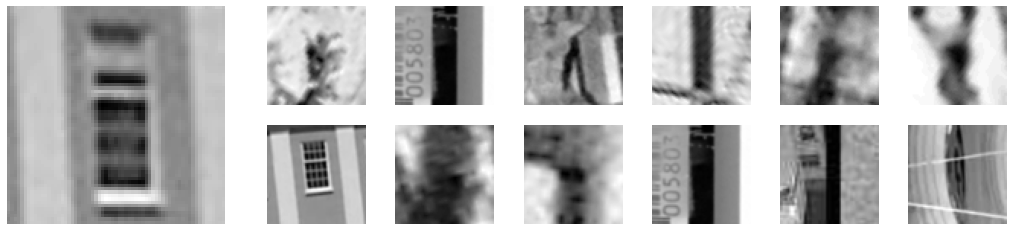

In [35]:
generate_visualisation_for_3_descrs(x_queries, y_queries, results_patches_x_coords_0, results_patches_y_coords_0,
                                        results_patches_x_coords_1, results_patches_y_coords_1,
                                        image)